# Understanding nighttime methane signals at the Amazon Tall Tower Observatory (ATTO)

### Santiago Botía B et al
#### Calculations and analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import seaborn as sns
import scipy
import matplotlib as mpl
%matplotlib inline

## Section 3.2.3 Turbulence regimes
- It is important to recall that this analysis is done with 1 min data for 2014
- Alternative plots and further calculations.

In [2]:
df_full_1min = pd.read_pickle('./to_Share/Data/df_GHG_uvw_1min_merged')
df_full_1min = df_full_1min.between_time('20:00','06:00',include_start=True,include_end=True)
df_full_1min.head();

In [3]:
# z over L functions. Transcribed from R by Santiago Botia, based on Michel Stefanello scripts.
##################################
def calc_1suL(T,wT,us):
    rc = get_rhocp(T)
    H0 = wT*rc
    #if wT.any() or rc.any() == np.nan:
    #    H0=np.nan
    #else:
    #    H0=wT*rc #Zannetti pag 59
    unosuL=hlm(rc,T,us,H0)
    return unosuL
def get_rhocp(Tm):
    rhocp = 1305*(273.16/Tm)
    #if Tm.any() < 0:
    #    rhocp = np.na
    #else:
    #    rhocp = 1305*(273.16/Tm)
    return rhocp
def hlm(rc,T,us,h0):
    hk = 0.4
    g  = 9.81
    hlm_2 = -(g*hk*h0)/(rc*T*us*us*us)
    #if T.isnull().any() or us.isnull().any() or T.any() < 0 or us.any() < 0:
    #    hlm_2=np.nan
    #else:
    #    hlm_2 = -(g*hk*h0)/(rc*T*us*us*us)
    return(hlm_2)  # output:1/L

## Stability Assessment for 1 min data, 2014 for dry and wet seasons
### Marht 1998 z/L ranges CASES 99
- (1) For the ‘weakly stable regime’ (0 < z/L < ε ≪ 1), the heat flux increases with increasing z/L due to increasing amplitude of the temperature fluctua- tions with increasing stability, where ε is the maximum stability for the weakly stable regime, equal to 0.06 for the 10 m data.
- (2) For the ‘transition stability regime’ (ε < z/L < O(1)), the heat flux decreases rapidly with increasing z/L due to decreasing amplitude of the vertical velocity fluctuations (Figure 1a) associated with stability constraints.
- (3) For the ‘very stable regime’ (z/L > O(1)), the heat flux is small but continues to decrease slowly with increasing stability.

### Bart Kruijt (2000) stability classes for Amazon forest study
- very unstable (1/Ltop < −0.1)
- moderately unstable (−0.1 < 1/Ltop < −0.01)
- neutral (−0.01 < 1/Ltop < 0.01)
- moderately stable (0.01 < 1/Ltop < 0.1) 
- very stable (1/Ltop > 0.1).

In [4]:
# calculating 1/L with one of the functions above
one_L        = calc_1suL(df_full_1min.mean_T+273.15,df_full_1min.wT,df_full_1min.Ustar)
df_full_1min = df_full_1min.assign(one_over_L = one_L) 
df_full_1min = df_full_1min.assign(Z_over_L = (81.65-20.1)*one_L) # Z = measurementH - displacement height (Given by Martha Sá)

In [5]:
# This is to confirm that for every Flag (True or False) use to mark the CH4 enhancements, 
# there is a corresponding number of 1/L or Z/L
# As the shape after and before removing nan are the same, we can continue.
print(df_full_1min.loc[:,['EnhanGrad','Z_over_L']].shape,df_full_1min.loc[:,['EnhanGrad','Z_over_L']].dropna().shape)
print(df_full_1min.loc[:,['EnhanGrad','one_over_L']].shape,df_full_1min.loc[:,['EnhanGrad','one_over_L']].dropna().shape)

(108621, 2) (108621, 2)
(108621, 2) (108621, 2)


count    108621.000000
mean          0.029103
std          25.911796
min       -8348.301372
25%          -0.030777
50%           0.034766
75%           0.152200
max         974.122821
Name: one_over_L, dtype: float64 count    108621.000000
mean          1.791308
std        1594.871073
min     -513837.949460
25%          -1.894315
50%           2.139828
75%           9.367880
max       59957.259631
Name: Z_over_L, dtype: float64


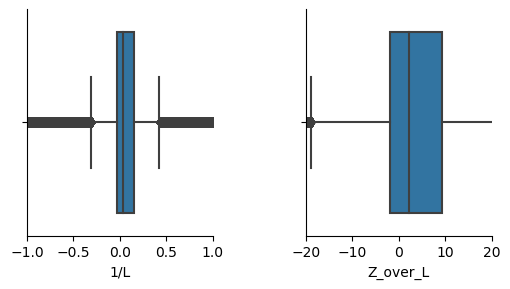

In [6]:
# Plotting distributions of 1/L and Z/L
fig  = plt.figure(figsize=(6,3),dpi=100)
grid = plt.GridSpec(1,2,wspace=0.5,hspace=0.1)

print(df_full_1min.one_over_L.describe(),df_full_1min.Z_over_L.describe())
## Top panel
ax1     = fig.add_subplot(grid[0, 0])
sns.boxplot(df_full_1min.one_over_L,ax=ax1)
ax1.set_xlabel('1/L')
ax1.set_xlim(-1,1)
sns.despine()

## Row 2 panel
ax2    = fig.add_subplot(grid[0,1])
sns.boxplot(df_full_1min.Z_over_L,ax=ax2)
ax2.set_xlim(-20,20)
sns.despine()
plt.show()

#### Here I am constraining the analysis for the data within the whiskers to avoid large outliers

In [7]:
# 1/L Kruijt, calculating the IQR based on the numbers above
IQR     = df_full_1min.one_over_L.describe()[6] - df_full_1min.one_over_L.describe()[4]
loval_k = df_full_1min.one_over_L.describe()[4] - 1.5 * IQR
hival_k = df_full_1min.one_over_L.describe()[6] + 1.5 * IQR
print(loval_k,hival_k)

# Marht, calculating the IQR based on the numbers above
IQR     = df_full_1min.Z_over_L.describe()[6] - df_full_1min.Z_over_L.describe()[4]
loval_m = df_full_1min.Z_over_L.describe()[4] - 1.5 * IQR
hival_m = df_full_1min.Z_over_L.describe()[6] + 1.5 * IQR
print(loval_m,hival_m)

-0.305241401873438 0.4266640546736604
-18.78760828531011 26.261172565163797


In [9]:
# Defining classes according to Marht's regimes
bins         = [loval_m,0,0.06,1,hival_m] 
df_full_1min = df_full_1min.assign(z_over_L_class_marht =  pd.cut(df_full_1min.Z_over_L,bins))

# Defining classes according to Kruijt's classes
bins    = [loval_k,-0.1,-0.01,0.01,0.1,hival_k] # limiting distribution 
# I used this one on the paper to avoid large outliers
# bins         = [df_full_1min.one_over_L.min(),-0.1,-0.01,0.01,0.1,df_full_1min.one_over_L.max()] # inlcuding all distribution
# using the above bins, assures that the percentages add up to 100
df_full_1min = df_full_1min.assign(one_over_L_class_kruijt =  pd.cut(df_full_1min.one_over_L,bins,labels=
                                                                     ['very uns','mod unst','neutral','mod stabl','very stable']))

#### Note that by pd.cutting the one_over_L with the bins above, which limit the distribution, I am leaving outliers out and therefore adding NaN to the column (one_over_L_class_kruijt)
- The following cell creates a flag for indicating were do we have NaN

In [10]:
# Flag for where the intervals of 1/L could be calculated
df_full_1min = df_full_1min.assign(one_L_Flag = df_full_1min['one_over_L_class_kruijt'].isnull()) # True indicates where nan values are
df_full_1min = df_full_1min.assign(z_over_L_Flag = df_full_1min['z_over_L_class_marht'].isnull()) # True indicates where n

In [11]:
# Total enhancement events at 1 min for all distribution
EnhanGradTotal   = df_full_1min['EnhanGrad'].sum() # this is the total of positive gradient events.
ncol_with_one_L  = df_full_1min.shape[0] - df_full_1min['one_L_Flag'].sum() # Number of rows with True values in z_L and 1_L
ncol_with_z_L    = df_full_1min.shape[0] - df_full_1min['z_over_L_Flag'].sum() # Number of rows with True values in z_L and 1_L
print(EnhanGradTotal,ncol_with_one_L,ncol_with_z_L)

20647 85846 85846


### Note that there are fewer positive gradients than there are one_over_L events.
-  This is because the other portion of the events are one the below-8-ppb class, but the one_over_L is not yet constrained to only positive gradients.

In [12]:
# Limiting the data set to only positive gradients (above-8-ppb)
df_lim_to_pos_grad = df_full_1min.loc[df_full_1min['EnhanGrad']==True,:]

In [13]:
df_lim_to_pos_grad.shape # This is the total datapoints to be analyzed.

(20647, 89)

In [14]:
ncol_with_one_L  = df_lim_to_pos_grad.shape[0] - df_lim_to_pos_grad['one_L_Flag'].sum() # Number of rows with True values in z_L and 1_L
ncol_with_z_L    = df_lim_to_pos_grad.shape[0] - df_lim_to_pos_grad['z_over_L_Flag'].sum() # Number of rows with True values in z_L and 1_L
print('From the total datpoints after filtering for positive gradients, there are 15993 that are usable with 1/L or z/L values, shapes = ',ncol_with_one_L,ncol_with_z_L)

From the total datpoints after filtering for positive gradients, there are 15993 that are usable with 1/L or z/L values, shapes =  15993 15993


In [15]:
# Now, we have to further constrain the data to where we actually values of L (z/L or 1/L)

## Number of enhanced CH$_4$ events in each stability class, according Marht and Kruijt
### Marht's approach
- This is not included, but have it here in case a reviewer ask for it

In [16]:
# new analysis with new dataframe limited to positive gradients.
# The filter for only z_over_L values is done here
# The total of positive gradients is calculated from the dataframe with limiting the distribution but taking 100% as the new population after filtering for outliers (gradTotal).
df_marht           = df_lim_to_pos_grad.loc[df_lim_to_pos_grad['z_over_L_Flag']==False,['EnhanGrad','z_over_L_class_marht']].groupby('z_over_L_class_marht').sum()
gradTotal          = df_lim_to_pos_grad.loc[df_lim_to_pos_grad['z_over_L_Flag']==False,'EnhanGrad'].sum()
df_marht           = df_marht.assign(Percentages = df_marht['EnhanGrad'] / gradTotal*100)
print(gradTotal)
print(df_marht['Percentages'].sum())
df_marht

15993
100.0


,EnhanGrad,Percentages
z_over_L_class_marht,,
"(-18.788, 0.0]",5023.0,31.407491
"(0.0, 0.06]",81.0,0.506472
"(0.06, 1.0]",1207.0,7.547052
"(1.0, 26.261]",9682.0,60.538986


In [18]:
# Using the limited distribution (no outliers in Z/L or 1/L) without constraining the df to positive gradients
# This gives the same as above because with the groupby.sum() we summ all the True booleans within each z_over_L class, if using count the False record are counted also. This is not what we want.
# The latter applies fot the cell below also
df_marht = df_full_1min.loc[df_full_1min['z_over_L_Flag']==False,['EnhanGrad','z_over_L_class_marht']].groupby('z_over_L_class_marht').sum()
gradTotal = df_full_1min.loc[df_full_1min['z_over_L_Flag']==False,'EnhanGrad'].sum()
print(gradTotal)
df_marht = df_marht.assign(Percentages = df_marht['EnhanGrad']/ gradTotal*100)
print(df_marht['Percentages'].sum())
df_marht

15993
100.0


,EnhanGrad,Percentages
z_over_L_class_marht,,
"(-18.788, 0.0]",5023.0,31.407491
"(0.0, 0.06]",81.0,0.506472
"(0.06, 1.0]",1207.0,7.547052
"(1.0, 26.261]",9682.0,60.538986


#### The following is the data used in Table 2. Kruijt et al (2000)
- the table was taken out of the manuscript. This was mainly because the unstable cases created confusion.
- The decision was moticated by a comment from a referee

In [19]:
df_kruijt          = df_lim_to_pos_grad.loc[df_lim_to_pos_grad['one_L_Flag']==False,['EnhanGrad','one_over_L_class_kruijt']].groupby('one_over_L_class_kruijt').sum()
gradTotal          = df_lim_to_pos_grad.loc[df_lim_to_pos_grad['one_L_Flag']==False,'EnhanGrad'].sum()
df_kruijt           = df_kruijt.assign(Percentages = df_kruijt['EnhanGrad'] / gradTotal*100)
print(gradTotal)
print(df_kruijt['Percentages'].sum())
df_kruijt

15993
100.00000000000001


,EnhanGrad,Percentages
one_over_L_class_kruijt,,
very uns,1967.0,12.299131
mod unst,2483.0,15.525542
neutral,1374.0,8.591259
mod stabl,5506.0,34.427562
very stable,4663.0,29.156506


In [20]:
# filtering for where I actually calculated the one_over_L_classes, constaining the total for the filttered distribution
df_kruijt = df_full_1min.loc[df_full_1min['one_L_Flag']==False,['EnhanGrad','one_over_L_class_kruijt']].groupby('one_over_L_class_kruijt').sum()
gradTotal = df_full_1min.loc[df_full_1min['one_L_Flag']==False,'EnhanGrad'].sum()
df_kruijt = df_kruijt.assign(Percentages = df_kruijt['EnhanGrad']/gradTotal*100)
print(df_kruijt['Percentages'].sum())
df_kruijt

100.00000000000001


,EnhanGrad,Percentages
one_over_L_class_kruijt,,
very uns,1967.0,12.299131
mod unst,2483.0,15.525542
neutral,1374.0,8.591259
mod stabl,5506.0,34.427562
very stable,4663.0,29.156506


In [21]:
# What I added to Table 2 in the paper, using all the distribution, does not add to 100
df_kruijt = df_full_1min.loc[df_full_1min['EnhanGrad']==True,['EnhanGrad','one_over_L_class_kruijt']].groupby('one_over_L_class_kruijt').sum()
df_kruijt = df_kruijt.assign(Percentages = df_kruijt['EnhanGrad']/EnhanGradTotal*100)
print(df_kruijt['Percentages'].sum())
df_kruijt

77.45919504044171


,EnhanGrad,Percentages
one_over_L_class_kruijt,,
very uns,1967.0,9.526808
mod unst,2483.0,12.025960
neutral,1374.0,6.654720
mod stabl,5506.0,26.667312
very stable,4663.0,22.584395


### Note that the percentages do not add up 100, because not all the distribution was considered.
- From this check, I realized that using the filtered 100% values for calculating the percentages, changes the picture a little bit, but not too much.

## Alternative plots based on the 1 min data
- Same plots as in Fig 9. but with 1 min data
- Additional analysis based on wind direction and wind speed bins

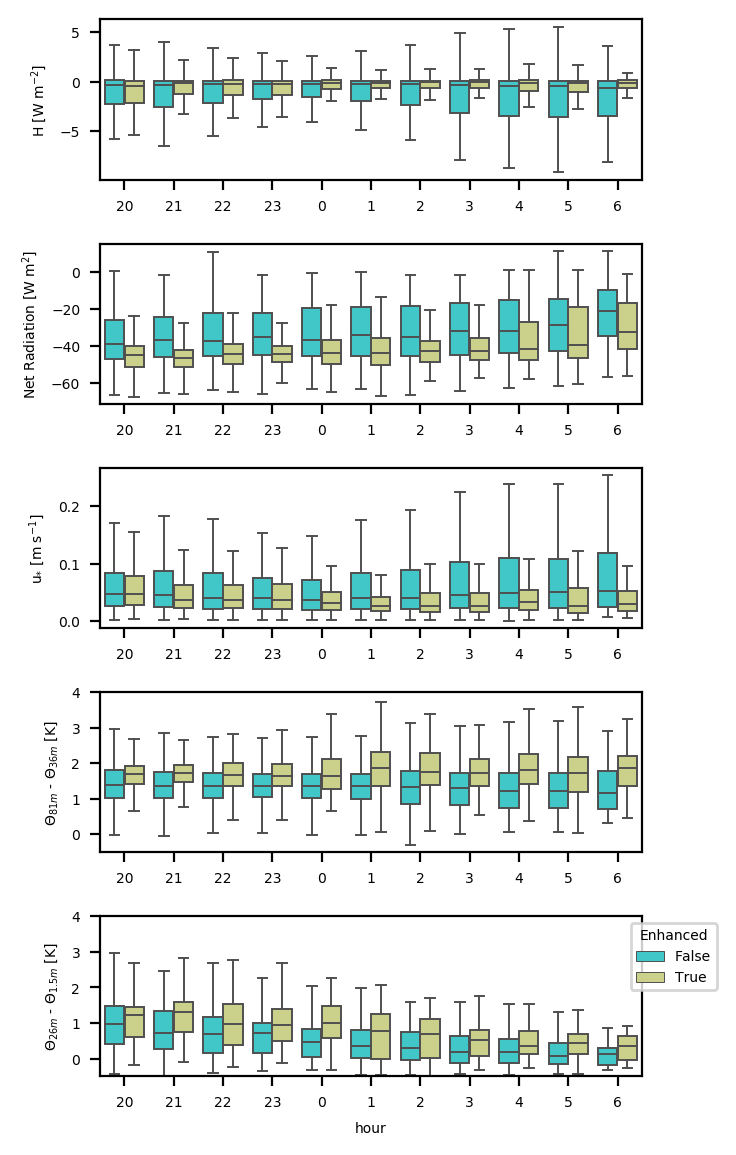

In [24]:
fig  = plt.figure(figsize=(3.5,7),dpi=200)
grid = plt.GridSpec(5,1,wspace=0.5,hspace=0.4)

ax1  = fig.add_subplot(grid[0, 0])
sns.boxplot(x=df_full_1min['hour'],y=df_full_1min['wT']*1004.67*1.2923,hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],
            data=df_full_1min,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
ax1.set_ylabel('H [W m$^{-2}$]')
ax1.set_xlabel(' ')
#ax1.set_xlabel('Nighttime Hours [Local Time]')
ax1.get_legend().remove()
#================================================================================================
ax2  = fig.add_subplot(grid[1, 0])
sns.boxplot(x='hour',y='Rnet',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax2,showmeans=False)
ax2.set_ylabel('Net Radiation [W m$^2$]')
ax2.set_xlabel(' ')
ax2.get_legend().remove()
#================================================================================================
ax3  = fig.add_subplot(grid[2, 0])
sns.boxplot(x='hour',y='Ustar',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax3)
ax3.set_ylabel('u$_{*}$ [m s$^{-1}$]')
ax3.set_xlabel(' ')
ax3.get_legend().remove()
#================================================================================================
ax4  = fig.add_subplot(grid[3, 0])
#df_full_1min        = df_full_1min.assign(PotGradAbove = df_full_1min.theta - df_full_1min.theta40)
df_full_1min        = df_full_1min.assign(PotGradAbove = df_full_1min.theta - df_full_1min.theta36)
df_full_1min        = df_full_1min.assign(PotGradWithin = df_full_1min.theta26 - df_full_1min.theta1_5)
sns.boxplot(x='hour',y='PotGradAbove',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax4)
ax4.set_ylabel('$\Theta_{81m}$ - $\Theta_{36m}$ [K]')
ax4.set_ylim(-0.5,4)
ax4.set_xlabel(' ')
ax4.get_legend().remove()
#================================================================================================
ax5  = fig.add_subplot(grid[4, 0])
sns.boxplot(x='hour',y='PotGradWithin',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax5)
ax5.set_ylim(-0.5,4)
ax5.set_ylabel('$\Theta_{26m}$ - $\Theta_{1.5m}$ [K]')
#================================================================================================
mpl.rcParams['font.size'] = 5
mpl.rcParams['lines.linewidth'] = 0.7
mpl.rcParams['figure.frameon'] = False

plt.legend(bbox_to_anchor=[1.15,1],title='Enhanced')
plt.show()

### Checking dTheta/dz for gradient events
- based on a comment from referee and Otavio's feedback

In [26]:
df_full_1min = df_full_1min.assign(dtheta_dz = df_full_1min["PotGradAbove"] / (81-40))
# Limits of dtheta_dz
df_full_1min.loc[df_full_1min['EnhanGrad']==True,'dtheta_dz'].describe()

count    20393.000000
mean         0.042892
std          0.014853
min         -0.009531
25%          0.033152
50%          0.041689
75%          0.051445
max          0.099250
Name: dtheta_dz, dtype: float64

#### Checking the dtheta/dz for nighttime hours.  
- Similar to Fig 9 on manuscript.

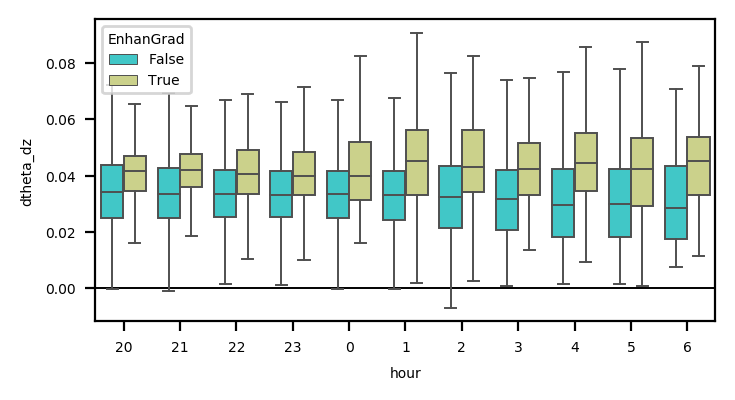

In [28]:
# Using 81 and 36 m levels
fig  = plt.figure(figsize=(4,2),dpi=200)
sns.boxplot(x='hour',y='dtheta_dz',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False)

plt.hlines(0,-0.5,12)
plt.xlim(-0.5,10.5)
plt.show()

In [29]:
# for positive gradient
df_full_1min = df_full_1min.assign(dtheta_dz_quant = pd.qcut(df_full_1min.dtheta_dz,q=4))
df_full_1min = df_full_1min.assign(dtheta_Flag     = df_full_1min['dtheta_dz'].isnull())

df_dt_dz     = df_full_1min.loc[df_full_1min['dtheta_Flag']==False,['EnhanGrad','dtheta_dz_quant','dtheta_Flag']].groupby('dtheta_dz_quant').sum()

#df_full_1min.loc[df_full_1min['one_L_Flag']==False,'EnhanGrad'].sum()
gradTotal    = df_dt_dz.loc[df_dt_dz['dtheta_Flag']==False,'EnhanGrad'].sum()
df_dt_dz     = df_dt_dz.assign(Percentages = df_dt_dz['EnhanGrad']/gradTotal*100)
print(df_dt_dz['Percentages'].sum(),gradTotal)
df_dt_dz

100.0 20393.0


,EnhanGrad,dtheta_Flag,Percentages
dtheta_dz_quant,,,
"(-0.0171, 0.0246]",1881.0,0.0,9.223753
"(0.0246, 0.0344]",3863.0,0.0,18.942774
"(0.0344, 0.0446]",6105.0,0.0,29.936743
"(0.0446, 0.13]",8544.0,0.0,41.896729


In [30]:
# for below 8 ppb gradient
df_full_1min = df_full_1min.assign(dtheta_dz_quant = pd.qcut(df_full_1min.dtheta_dz,q=4))
df_full_1min = df_full_1min.assign(dtheta_Flag     = df_full_1min['dtheta_dz'].isnull())

df_dt_dz     = df_full_1min.loc[df_full_1min['EnhanGrad']==False,['EnhanGrad','dtheta_dz_quant','dtheta_Flag']].groupby('dtheta_dz_quant').count()

gradTotal    = df_full_1min.loc[(df_full_1min['EnhanGrad']==False) & (df_full_1min['dtheta_Flag']==False)].shape[0]
df_dt_dz     = df_dt_dz.assign(Percentages = df_dt_dz['EnhanGrad']/gradTotal*100)
print(df_dt_dz['Percentages'].sum(),gradTotal)
df_dt_dz

100.0 83413


,EnhanGrad,dtheta_Flag,Percentages
dtheta_dz_quant,,,
"(-0.0171, 0.0246]",24313,24313,29.147735
"(0.0246, 0.0344]",21860,21860,26.206946
"(0.0344, 0.0446]",19856,19856,23.804443
"(0.0446, 0.13]",17384,17384,20.840876


In [31]:
# cutting at zero.. for stable and non stable contribution
bins         = pd.IntervalIndex.from_tuples([(-0.02,0),(0,0.1)])
df_full_1min = df_full_1min.assign(dtheta_dz_min_max = pd.cut(df_full_1min.dtheta_dz,bins))
df_dt_dz     = df_full_1min.loc[df_full_1min['EnhanGrad']==True,['EnhanGrad','dtheta_dz_min_max']].groupby('dtheta_dz_min_max').sum()

gradTotal    = df_full_1min.loc[(df_full_1min['EnhanGrad']==True) & (df_full_1min['dtheta_Flag']==False)].shape[0]
df_dt_dz     = df_dt_dz.assign(Percentages = df_dt_dz['EnhanGrad']/gradTotal*100)
print(df_dt_dz['Percentages'].sum())
df_dt_dz

100.0


,EnhanGrad,Percentages
dtheta_dz_min_max,,
"(-0.02, 0.0]",12.0,0.058844
"(0.0, 0.1]",20381.0,99.941156


### Notes
- the cells above checked the percentage of positive gradients for each quartile based on the total positive gradients or on the limited distribution
- The last cell used a different criteria for separating, min to zero and zero to max
- But now I have to see how was the dtheta/dz for each of the classes of Table 2 in the manuscript.

In [32]:
print(df_full_1min['EnhanGrad'].sum(), 'number of positive gradients')
print(df_full_1min['dtheta_dz'].shape[0] - df_full_1min['dtheta_dz'].isnull().sum(), 'number of dtheta_dz usable from the entire dataset')
print(df_full_1min['dtheta_dz'].shape[0] - df_full_1min['one_over_L_class_kruijt'].isnull().sum(), 'number of one_over_L classes usable from the entire dataset')

20647 number of positive gradients
103806 number of dtheta_dz usable from the entire dataset
85846 number of one_over_L classes usable from the entire dataset


In [33]:
# Here I groupby Kruijt's classes and extract the dtheta/dz together with the EnhanGrad Flag.
groups = ['very uns','mod unst','neutral','mod stabl','very stable']
#groups =  ['mod unst','neutral','mod stabl','very stable']
df     = df_full_1min[['EnhanGrad','dtheta_dz','one_over_L_class_kruijt','Ustar',"wT"]].groupby(by='one_over_L_class_kruijt')

In [34]:
# This is a shortcut for the things below... The manioulation below is to arrange the data for easily plotting boxplot with seaborn
df_full_1min.loc[df_full_1min['EnhanGrad']==True,['EnhanGrad','dtheta_dz','one_over_L_class_kruijt','Ustar','wT']].groupby(by='one_over_L_class_kruijt').mean()

,EnhanGrad,dtheta_dz,Ustar,wT
one_over_L_class_kruijt,,,,
very uns,True,0.044503,0.029874,0.000889
mod unst,True,0.043117,0.048065,0.001725
neutral,True,0.035685,0.120615,-0.002318
mod stabl,True,0.039743,0.074240,-0.003617
very stable,True,0.044062,0.036169,-0.001844


In [35]:
# checking shape of resulting groupby object
print(sum([df.get_group(i).shape[0] for i in groups]))
# This shows that the groupby object is constrained to the amount of one_over_L classes occurrences.
# Extracting groups from groupby object and concatenating in one df
df_gro = pd.concat([df.get_group(i) for i in groups])
df_gro.head(3)

85846


,EnhanGrad,dtheta_dz,one_over_L_class_kruijt,Ustar,wT
2014-02-28 20:29:00,False,0.020957,very uns,0.048834,0.002142
2014-02-28 20:31:00,False,0.024860,very uns,0.041982,0.000685
2014-02-28 20:40:00,False,0.023396,very uns,0.036998,0.000806


In [36]:
# Limiting the df to the enhancement events
print(df_gro.shape)
df_gro = df_gro.loc[df_gro['EnhanGrad']==True,:]
df_gro.shape

(85846, 5)


(15993, 5)

In [37]:
# Checking is there are still nan in one of the following
df_gro['dtheta_dz'].isnull().sum(),df_gro['one_over_L_class_kruijt'].isnull().sum(),df_gro['Ustar'].isnull().sum()

(136, 0, 0)

In [38]:
melt = pd.melt(df_gro,id_vars=['one_over_L_class_kruijt','EnhanGrad','Ustar','wT'],value_vars='dtheta_dz')
melt.head()

,one_over_L_class_kruijt,EnhanGrad,Ustar,wT,variable,value
0,very uns,True,0.191829,0.057203,dtheta_dz,0.009982
1,very uns,True,0.202100,0.111465,dtheta_dz,0.009494
2,very uns,True,0.157940,0.046501,dtheta_dz,0.009982
3,very uns,True,0.164770,0.072260,dtheta_dz,0.010713
4,very uns,True,0.133040,0.048555,dtheta_dz,0.010225


In [39]:
# Percentages.. Same as above
melt.groupby(by='one_over_L_class_kruijt').sum()['EnhanGrad']/df_gro.shape[0]*100

one_over_L_class_kruijt
very uns       12.299131
mod unst       15.525542
neutral         8.591259
mod stabl      34.427562
very stable    29.156506
Name: EnhanGrad, dtype: float64

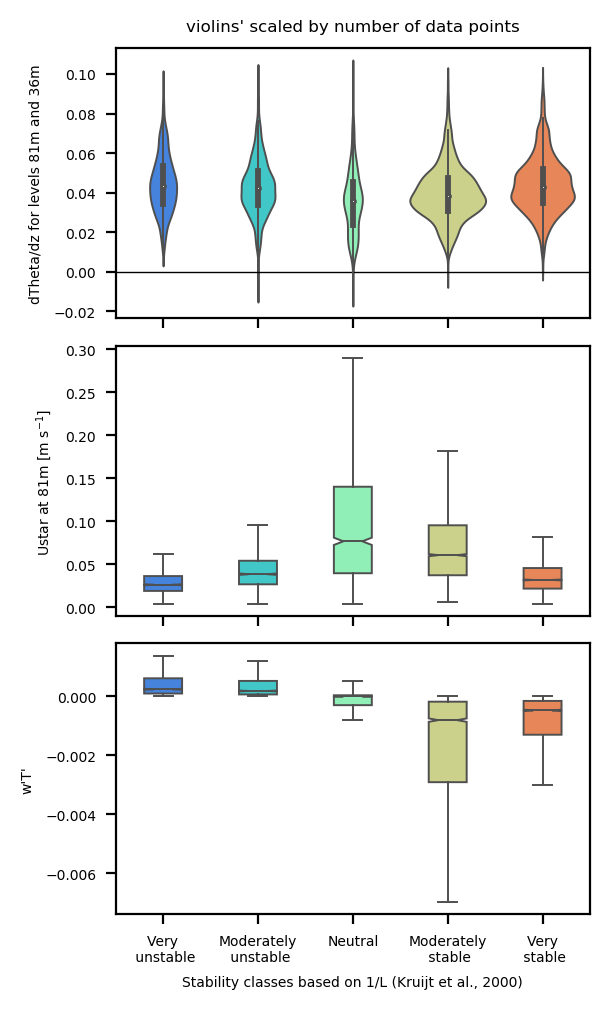

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(3,5),dpi=200,sharex=True)
#sns.boxplot(x='one_over_L_class_kruijt',y='dtheta_dz',data=melt,ax=ax1,notch=True,fliersize=1,palette=sns.color_palette(palette="rainbow",n_colors=5))
sns.violinplot(x='one_over_L_class_kruijt',y='value',data=melt,ax=ax1,palette=sns.color_palette(palette="rainbow",n_colors=5),scale='count')
sns.boxplot(x='one_over_L_class_kruijt',y='Ustar',data=melt,notch=True,showfliers=False,palette=sns.color_palette(palette="rainbow",n_colors=5),ax=ax2,width=0.4)
sns.boxplot(x='one_over_L_class_kruijt',y='wT',data=melt,ax=ax3,notch=True,showfliers=False,palette=sns.color_palette(palette="rainbow",n_colors=5),width=0.4)

ax1.hlines(0,-1,100,lw=0.5)
ax1.set_xlim(-0.5,4.5)
ax1.set_ylabel('dTheta/dz for levels 81m and 36m')
ax1.set_xlabel(' ')
ax1.set_xticklabels(['Very\n unstable','Moderately\n unstable','Neutral','Moderately\n stable','Very\n stable'])
ax1.set_title('violins\' scaled by number of data points')

ax2.set_ylabel('Ustar at 81m [m s$^{-1}$]')
ax2.set_xlabel(' ')

ax3.set_xlabel('Stability classes based on 1/L (Kruijt et al., 2000)')
ax3.set_ylabel('w\'T\'')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()
#fig.savefig('../Rebuttal/dtheta_dz_Ustar_wT_nightime_1min_nighttime_pos_grad.png',dpi=300)

### Alternative wind direction plots

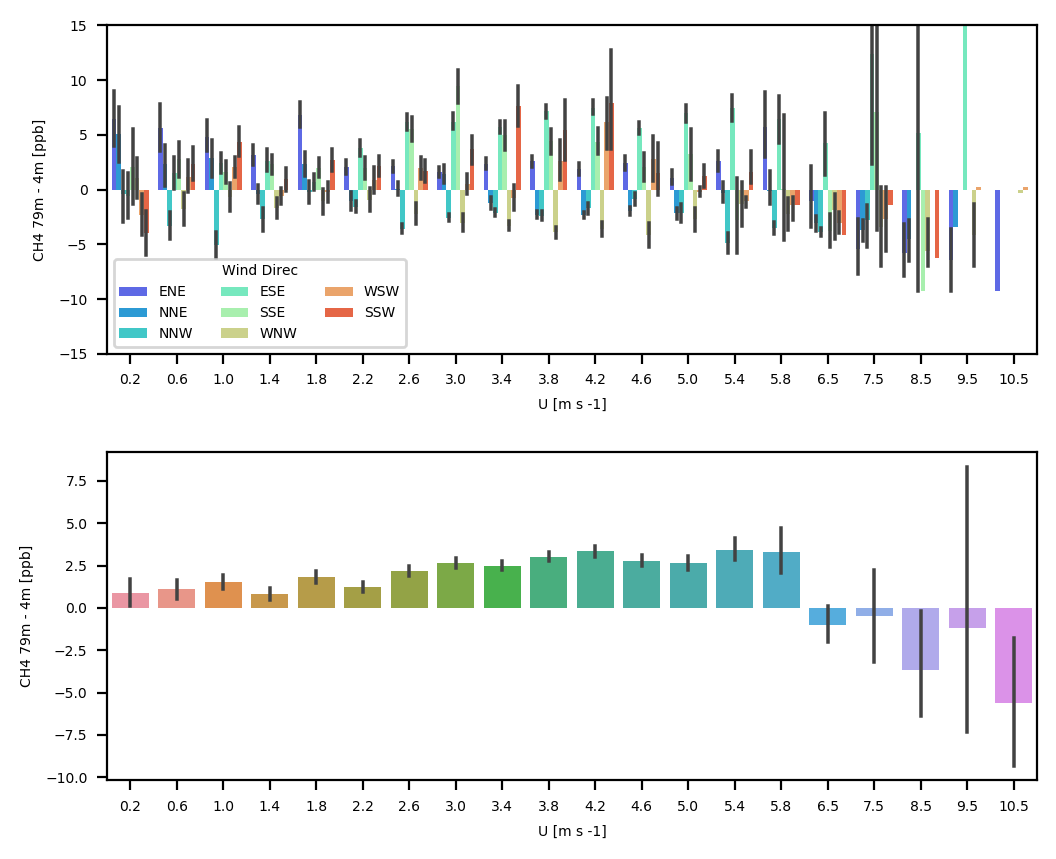

In [41]:
fig  = plt.figure(figsize=(6,5),dpi=200)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=8),showfliers=False,ax=ax1)
sns.barplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=8),ax=ax1)
labels     = ['%.1f'%(i) for i in sorted(list(set(df_full_1min['WindClassMid'].values)))]
ax1.set_xticklabels(labels)
ax1.set_ylabel('CH4 79m - 4m [ppb]')
ax1.legend(loc='lower left',title='Wind Direc',ncol=3)
ax1.set_xlabel('U [m s -1]')
ax1.set_xlim(-0.5,19.5)
ax1.set_ylim(-15,15)

ax2  = fig.add_subplot(grid[1, 0])
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=8),showfliers=False,ax=ax1)
#sns.barplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),ax=ax1)
sns.barplot(x='WindClassMid',y='CH4_grad',data=df_full_1min,ax=ax2)
labels     = ['%.1f'%(i) for i in sorted(list(set(df_full_1min['WindClassMid'].values)))]
#labels[-2] = '12.5'
#labels[-1] = '12.5'
labels.append('13.5')

ax2.set_ylabel('CH4 79m - 4m [ppb]')
ax2.set_xticklabels(labels)
ax2.set_xlabel('U [m s -1]')
ax2.set_xlim(-0.5,19.5)
#plt.ylim(-15,60)
plt.show()